<a href="https://colab.research.google.com/github/Shujaat123/Ear_Biometrics/blob/main/Generalized_Code_for_LSE_Pytorch_Implementation_Ear_Biometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Load useful packages
!pip install wget
!pip install py7zr

In [2]:
import py7zr
from zipfile import ZipFile
from random import sample
import PIL.Image as Image
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split
import os
import h5py
import numpy as np
import wget
from zipfile import ZipFile


In [3]:
data_path = 'https://raw.githubusercontent.com/Shujaat123/Ear_Biometrics/main/utilities.py'
filename = 'utilities.py'

if(os.path.exists(filename)):
  !rm $filename
  print('existing file:', filename, ' has been deleted')
print('downloading latest version of file:', filename)
wget.download(data_path, filename)
print('sucessfully downloaded')

existing file: utilities.py  has been deleted
downloading latest version of file: utilities.py
sucessfully downloaded


In [4]:
from utilities import load_dataset
# LOADING Dataset
# ear_images, sub_labels = load_dataset(dataset='AMI', target_size =(246, 351))
ear_images, sub_labels = load_dataset(dataset='IITD_dataset', target_size = (50, 180))

existing file: IITD_Dataset.7z  has been deleted
downloading latest version of file: IITD_Dataset.7z
sucessfully downloaded
['.config', 'AMI_dataset.zip', 'ear', '__pycache__', 'AMI_dataset', '.ipynb_checkpoints', 'IITD_Dataset.7z', 'utilities.py', 'sample_data']
[1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52, 52, 52, 53, 53, 

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(ear_images, sub_labels, test_size=0.142, random_state=42, stratify=sub_labels)
X_train, X_test, y_train, y_test = train_test_split(ear_images, sub_labels, test_size=0.382093316519, random_state=42, stratify=sub_labels)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.386363636363, random_state=42, stratify=y_train)

print('Training dataset:\n',X_train.shape)
print(y_train.shape)
# print('Validation dataset:\n',X_valid.shape)
# print(y_valid.shape)
print('Test dataset:\n',X_test.shape)
print(y_test.shape)

Training dataset:
 (490, 1, 180, 50)
(490,)
Test dataset:
 (303, 1, 180, 50)
(303,)


# Conventional convolution

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn
import torch.nn.functional
import torch.optim
from torchvision import models #just for debugging

In [7]:
class Feature_Extraction_Module(torch.nn.Module):
  #  Determine what layers and their order in CNN object
  def __init__(self, num_classes=221, num_filters=8, input_shape=(180,50,3)):
    super(Feature_Extraction_Module,self).__init__()
    #self.encoder_input = input_shape[-1]
    kernel_size = 3
    # Encoder Layer1
    self.encoder_layer1_name = 'encoder_layer1'
    self.encoder_layer1_conv = torch.nn.Conv2d(input_shape[2],
                                               num_filters,
                                               kernel_size,
                                               padding='same')

    self.encoder_layer1_activation = torch.nn.ReLU()
    self.encoder_layer1_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer2
    self.encoder_layer2_name = 'encoder_layer2'
    self.encoder_layer2_conv = torch.nn.Conv2d(num_filters,
                                               2*num_filters,
                                               kernel_size,
                                               padding='same')
    self.encoder_layer2_activation = torch.nn.ReLU()
    self.encoder_layer2_batch_norm = torch.nn.BatchNorm2d(2*num_filters,
                                                          eps = 1e-3,
                                                          momentum = 0.99)
    self.encoder_layer2_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer3
    self.encoder_layer3_name = 'encoder_layer3'
    self.encoder_layer3_conv = torch.nn.Conv2d(2*num_filters,
                                               4*num_filters,
                                               kernel_size,
                                               padding='same')
    self.encoder_layer3_activation = torch.nn.ReLU()
    self.encoder_layer3_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer4
    self.encoder_layer4_name = 'encoder_layer4'
    self.encoder_layer4_conv = torch.nn.Conv2d(4*num_filters,
                                               8*num_filters,
                                               kernel_size,
                                               padding='same')
    self.encoder_layer4_activation = torch.nn.ReLU()
    self.encoder_layer4_batch_norm = torch.nn.BatchNorm2d(8*num_filters,
                                                          eps = 1e-3,
                                                          momentum = 0.99)
    self.encoder_layer4_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer5
    self.encoder_layer5_name = 'encoder_layer5'
    self.encoder_layer5_conv = torch.nn.Conv2d(8*num_filters,
                                               16*num_filters,
                                               kernel_size,
                                               padding='same')

    self.encoder_layer5_activation = torch.nn.ReLU()
    self.encoder_layer5_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

   # Encoder Layer6
    self.encoder_layer6_name = 'encoder_layer2'
    self.encoder_layer6_conv = torch.nn.Conv2d(16*num_filters,
                                               32*num_filters,
                                               kernel_size,
                                               padding='same')
    self.encoder_layer6_activation = torch.nn.ReLU()
    self.encoder_layer6_batch_norm = torch.nn.BatchNorm2d(32*num_filters,
                                                          eps = 1e-3,
                                                          momentum = 0.99)
    # Dense layer
    # self.fc1_flatten = torch.nn.Flatten()
    # self.fc1_linear = torch.nn.Linear(32*num_filters*(input_shape[0]//(2**5))*(input_shape[1]//(2**5)), num_classes)
    # self.fc1_activation = torch.nn.Softmax()

  def forward(self,x):
    # Encoder Layer1
    out = self.encoder_layer1_conv(x)
    out = self.encoder_layer1_activation(out)
    out = self.encoder_layer1_pooling(out)

    # Encoder Layer2
    out = self.encoder_layer2_conv(out)
    out = self.encoder_layer2_activation(out)
    out = self.encoder_layer2_batch_norm(out)
    out = self.encoder_layer2_pooling(out)

    # Encoder Layer3
    out = self.encoder_layer3_conv(out)
    out = self.encoder_layer3_activation(out)
    out = self.encoder_layer3_pooling(out)

    # Encoder Layer4
    out = self.encoder_layer4_conv(out)
    out = self.encoder_layer4_activation(out)
    out = self.encoder_layer4_batch_norm(out)
    out = self.encoder_layer4_pooling(out)

    # Encoder Layer5
    out = self.encoder_layer5_conv(out)
    out = self.encoder_layer5_activation(out)
    out = self.encoder_layer5_pooling(out)

    # Encoder Layer6
    out = self.encoder_layer6_conv(out)
    out = self.encoder_layer6_activation(out)
    out = self.encoder_layer6_batch_norm(out)

    # # Dense Layer
    # out = self.fc1_flatten(out)
    # out = self.fc1_linear(out)
    # out = self.fc1_activation(out)

    return out

In [8]:
class Feature_Decoder_Module(torch.nn.Module):
  #  Determine what layers and their order in CNN object
  def __init__(self, num_classes=221, num_filters=8, input_shape=(180,50,3)):
    super(Feature_Decoder_Module,self).__init__()
    #self.encoder_input = input_shape[-1]
    kernel_size = 3
    # Encoder Layer1
    self.encoder_layer1_name = 'encoder_layer1'
    self.encoder_layer1_conv = torch.nn.Conv2d(num_filters,
                                               input_shape[2],
                                               kernel_size,
                                               padding='same')

    self.encoder_layer1_activation = torch.nn.ReLU()
    self.encoder_layer1_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer2
    self.encoder_layer2_name = 'encoder_layer2'
    self.encoder_layer2_conv = torch.nn.ConvTranspose2d(2*num_filters,
                                               num_filters,
                                               kernel_size, stride=2, padding=(0,0), output_padding=(0,0))
    self.encoder_layer2_activation = torch.nn.ReLU()
    self.encoder_layer2_batch_norm = torch.nn.BatchNorm2d(num_filters,
                                                          eps = 1e-3,
                                                          momentum = 0.99)
    self.encoder_layer2_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer3
    self.encoder_layer3_name = 'encoder_layer3'
    self.encoder_layer3_conv = torch.nn.ConvTranspose2d(4*num_filters,
                                               2*num_filters,
                                               kernel_size, stride=2, padding=(0,0), output_padding=(0,0))
    self.encoder_layer3_activation = torch.nn.ReLU()
    # self.encoder_layer3_pooling = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # Encoder Layer4
    self.encoder_layer4_name = 'encoder_layer4'
    self.encoder_layer4_conv = torch.nn.ConvTranspose2d(8*num_filters,
                                               4*num_filters,
                                               kernel_size, stride=2, padding=(0,0), output_padding=(0,0))
    self.encoder_layer4_activation = torch.nn.ReLU()
    self.encoder_layer4_batch_norm = torch.nn.BatchNorm2d(4*num_filters,
                                                          eps = 1e-3,
                                                          momentum = 0.99)

    # Encoder Layer5
    self.encoder_layer5_name = 'encoder_layer5'
    self.encoder_layer5_conv = torch.nn.ConvTranspose2d(16*num_filters,
                                               8*num_filters,
                                               kernel_size, stride=2, padding=(0,0), output_padding=(0,0))

    self.encoder_layer5_activation = torch.nn.ReLU()

   # Encoder Layer6
    self.encoder_layer6_name = 'decoder_layer6'
    self.encoder_layer6_conv = torch.nn.ConvTranspose2d(32*num_filters,
                                               16*num_filters,
                                               kernel_size, stride=2, padding=(0,0), output_padding=(0,0))
    self.encoder_layer6_activation = torch.nn.ReLU()
    self.encoder_layer6_batch_norm = torch.nn.BatchNorm2d(16*num_filters,
                                                          eps = 1e-3,
                                                          momentum = 0.99)

    # Dense layer
    # self.fc1_flatten = torch.nn.Flatten()
    # self.fc1_linear = torch.nn.Linear(32*num_filters*(input_shape[0]//(2**5))*(input_shape[1]//(2**5)), num_classes)
    # self.fc1_activation = torch.nn.Softmax()

  def forward(self,x):

    # Encoder Layer6
    out = self.encoder_layer6_conv(x)
    out = self.encoder_layer6_activation(out)
    out = self.encoder_layer6_batch_norm(out)

    # Encoder Layer5
    out = self.encoder_layer5_conv(out)
    out = self.encoder_layer5_activation(out)
    # out = self.encoder_layer5_pooling(out)

    # Encoder Layer4
    out = self.encoder_layer4_conv(out)
    out = self.encoder_layer4_activation(out)
    out = self.encoder_layer4_batch_norm(out)
    # out = self.encoder_layer4_pooling(out)

    # Encoder Layer3
    out = self.encoder_layer3_conv(out)
    out = self.encoder_layer3_activation(out)
    # out = self.encoder_layer3_pooling(out)

    # Encoder Layer2
    out = self.encoder_layer2_conv(out)
    out = self.encoder_layer2_activation(out)
    out = self.encoder_layer2_batch_norm(out)
    # out = self.encoder_layer2_pooling(out)

    # Encoder Layer1
    out = self.encoder_layer1_conv(out)
    out = self.encoder_layer1_activation(out)
    # out = self.encoder_layer1_pooling(out)

    return out


In [9]:
class Classifier_Module(torch.nn.Module):
  #  Determine what layers and their order in CNN object
  def __init__(self, num_classes=221, num_filters=8, input_shape=(180,50,3)):
    super(Classifier_Module,self).__init__()

    # Dense layer
    self.fc1_flatten = torch.nn.Flatten()
    self.fc1_linear = torch.nn.Linear(32*num_filters*(input_shape[0]//(2**5))*(input_shape[1]//(2**5)), num_classes)
    self.fc1_activation = torch.nn.Softmax()

  def forward(self,x):
    # Dense Layer
    out = self.fc1_flatten(x)
    out = self.fc1_linear(out)
    out = self.fc1_activation(out)

    return out

In [10]:
class LSE_model(torch.nn.Module):
  #  Determine what layers and their order in CNN object
  def __init__(self, num_classes=100, num_filters=8, input_shape=(180,50,3)):
    super(LSE_model,self).__init__()

    self.feature_extraction_module = Feature_Extraction_Module(num_classes=num_classes, num_filters=num_filters, input_shape=input_shape)
    self.classification_module = Classifier_Module(num_classes=num_classes, num_filters=num_filters, input_shape=input_shape)
    self.feature_decoder_module = Feature_Decoder_Module(num_classes=num_classes, num_filters=num_filters, input_shape=input_shape)

  def forward(self,x):
    # Encoder Layer1
    encoded_output = self.feature_extraction_module(x)
    out = self.classification_module(encoded_output)
    decoded_output = self.feature_decoder_module(encoded_output)
    return out, decoded_output[:,:,0:input_shape[0],0:input_shape[1]]

In [11]:
!pip install torchinfo

In [12]:
from torchinfo import summary
num_classes=np.unique(y_train).shape[0]
num_filters=8
input_shape=(X_train.shape[2],X_train.shape[3],X_train.shape[1])
# input_shape=(702,492,3)
# feature_extraction_module = Feature_Extraction_Module(num_classes=num_classes, num_filters=num_filters, input_shape=input_shape)
# print((1, input_shape[2], input_shape[0], input_shape[1]))
# summary(feature_extraction_module, input_size=(1, input_shape[2], input_shape[0], input_shape[1]))
# classifier_module = Classifier_Module(num_classes=num_classes, num_filters=num_filters, input_shape=input_shape)
# print((1,32*num_filters,(input_shape[0]//(2**5)),(input_shape[1]//(2**5))))
# summary(classifier_module, input_size=(1,32*num_filters,(input_shape[0]//(2**5)),(input_shape[1]//(2**5))))
# feature_decoder_module = Feature_Decoder_Module(num_classes=num_classes, num_filters=num_filters, input_shape=input_shape)
# print((1,32*num_filters,(input_shape[0]//(2**5)),(input_shape[1]//(2**5))))
# summary(feature_decoder_module, input_size=(1,32*num_filters,(input_shape[0]//(2**5)),(input_shape[1]//(2**5))))
model = LSE_model(input_shape=input_shape)
summary(model, input_size=(1, input_shape[2], input_shape[0],input_shape[1]))

<ipython-input-9-b0cf55017268>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.fc1_activation(out)


Layer (type:depth-idx)                   Output Shape              Param #
LSE_model                                [1, 100]                  --
├─Feature_Extraction_Module: 1-1         [1, 256, 5, 1]            --
│    └─Conv2d: 2-1                       [1, 8, 180, 50]           80
│    └─ReLU: 2-2                         [1, 8, 180, 50]           --
│    └─MaxPool2d: 2-3                    [1, 8, 90, 25]            --
│    └─Conv2d: 2-4                       [1, 16, 90, 25]           1,168
│    └─ReLU: 2-5                         [1, 16, 90, 25]           --
│    └─BatchNorm2d: 2-6                  [1, 16, 90, 25]           32
│    └─MaxPool2d: 2-7                    [1, 16, 45, 12]           --
│    └─Conv2d: 2-8                       [1, 32, 45, 12]           4,640
│    └─ReLU: 2-9                         [1, 32, 45, 12]           --
│    └─MaxPool2d: 2-10                   [1, 32, 22, 6]            --
│    └─Conv2d: 2-11                      [1, 64, 22, 6]            18,496
│    

(490, 1, 180, 50) torch.Size([490, 1, 180, 50])


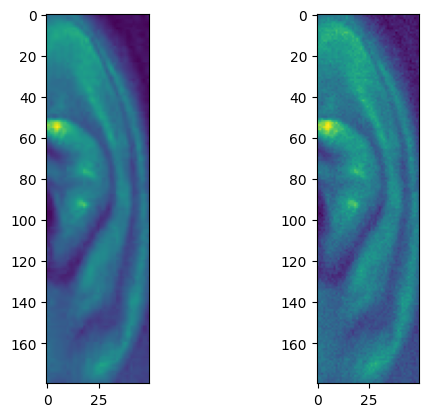

In [13]:
import random
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        if(random.choice([0, 1])):
          return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
          return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

import torchvision.transforms as T

transform = T.Compose(
    [
        # T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        # T.RandomRotation((-5,5)),
        # T.RandomAffine(degrees=(-5, 5), translate=(0, 0.3), scale=(0.5, 1.5)),
        # T.RandomVerticalFlip(p=0.25),
        # T.RandomHorizontalFlip(p=0.25),
        # T.ElasticTransform(alpha=10.0),
        AddGaussianNoise(0., 0.02)
    ]
)
transformed_X_train = transform(torch.tensor(X_train))
print(X_train.shape, transformed_X_train.shape)

plt.figure()
plt.subplot(1,2,1)
if (len(X_train[0].squeeze().shape)>2):
  plt.imshow(np.transpose(X_train[0].squeeze(),(1,2,0)))
  plt.subplot(1,2,2)
  plt.imshow(np.transpose(transformed_X_train[0].squeeze(),(1,2,0)))
else:
  plt.imshow(X_train[0].squeeze())
  plt.subplot(1,2,2)
  plt.imshow(transformed_X_train[0].squeeze())

In [14]:
#data
training_loader = DataLoader(TensorDataset(transform(torch.tensor(X_train)), torch.tensor(y_train)), batch_size=100, shuffle=True)
validation_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=1)
# training_loader = DataLoader(TensorDataset(transform(torch.tensor(X_train)), torch.tensor(y_train)), batch_size=10, pin_memory='True', pin_memory_device='cuda', shuffle=True)
# training_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=1, pin_memory='True', pin_memory_device='cuda', shuffle=True)
# validation_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=1, pin_memory='True', pin_memory_device='cuda')
#loss function
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn2 = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
# loss_fn = torch.nn.BCEWithLogitsLoss()
# Optimizers specified in the torch.optim package
# optimizer_lse = torch.optim.Adam(feature_extraction_module.parameters())
# optimizer_classifier = torch.optim.Adam(classifier_module.parameters())
# optimizer = torch.optim.Adam(pytorch_model_c1.parameters())
# optimizer = torch.optim.Adam(LSE_model.parameters())

# # import EarlyStopping
# from pytorchtools import EarlyStopping

In [15]:

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

num_classes=np.unique(y_train).shape[0]
num_filters=8
input_shape=(X_train.shape[2],X_train.shape[3],X_train.shape[1])
model = LSE_model(num_classes=num_classes, num_filters=num_filters,input_shape=input_shape).to(torch.device('cuda'))
optimizer = torch.optim.Adam(model.parameters())

# manaul training
def train_one_epoch(lambda1=0.5):
    # training metrics
    train_loss = 0
    train_correct = 0

    # validation metrics
    valid_loss = 0
    valid_correct = 0


    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    model.train(True)
    for i, data in enumerate(training_loader,0):
        # Every data instance is an input + label pair
        train_input, train_label = data
        # train_input = train_input.unsqueeze(dim=1).float()
        train_label= torch.tensor(to_categorical(y=train_label, num_classes=num_classes)).float()
        # train_label = train_label[:,None]
        if len(train_label.shape)==1:
          train_label = train_label.unsqueeze(dim=0)

        train_input = train_input.to(torch.device('cuda'))
        train_label = train_label.to(torch.device('cuda'))

        # print('train_input:',train_input.shape, 'train_label:',train_label.shape)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # optimizer_classifier.zero_grad()

        # Make predictions for this batch
        # train_features_output = feature_extraction_module(train_input)
        # train_output = classifier_module(train_features_output)
        # train_output = pytorch_model_c1(train_input)
        train_output, decoded_input = model(train_input)

        # print('train_input:',train_input.shape, 'train_label:',train_label.shape, 'train_output:',train_output.shape)
        # print('train_label:',train_label)
        # print('train_output:',train_output)

        # Compute the loss and its gradients
        loss = 2*(lambda1)*loss_fn(train_output, train_label)
        loss = loss + 2*(1-lambda1)*loss_fn2(train_input, decoded_input)

        loss.backward()

        # Adjust learning weights
        optimizer.step()
        # optimizer_classifier.step()

        # Gather data and report
        train_loss += loss.item()
        for batch_count in range(train_output.shape[0]):
          if(torch.argmax(train_output[batch_count,:]) == torch.argmax(train_label[batch_count,:])):
            train_correct += 1

    # print('training epoch complete')
    # Here, we use enumerate(validation_loader) instead of
    # iter(validation_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    model.train(False)
    for i, data in enumerate(validation_loader,0):
        # Every data instance is an input + label pair
        valid_input, valid_label = data

        # valid_input = valid_input.unsqueeze(dim=1).float()
        valid_label= torch.tensor(to_categorical(y=valid_label, num_classes=num_classes)).float()
        if len(valid_label.shape)==1:
          valid_label = valid_label.unsqueeze(dim=0)

        valid_input = valid_input.to(torch.device('cuda'))
        valid_label = valid_label.to(torch.device('cuda'))

        # Make predictions for this batch
        valid_output, temp = model(valid_input)

        # print('valid_input:',valid_input.shape, 'valid_label:',valid_label.shape, 'valid_output:',valid_output.shape)

        # Gather data and report
        valid_loss += loss_fn(valid_output, valid_label).item() + loss_fn2(valid_input, temp).item()
        for batch_count in range(valid_output.shape[0]):
          if(torch.argmax(valid_output[batch_count,:]) == torch.argmax(valid_label[batch_count,:])):
            valid_correct += 1

    print(f"Training: \n Training Accuracy: {100*train_correct/len(training_loader.dataset)}%, Average Training Loss: {train_loss/len(training_loader)}")

    print(f"Validation: \n Validation Accuracy: {100*valid_correct/len(validation_loader.dataset)}%, Average Validation Loss: {valid_loss/len(validation_loader)}")

    return train_loss, valid_loss


In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0
EPOCHS = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # if (epoch<3):
    #   lambda1=0
    # elif ((epoch>=3)&(epoch<10)):
    #   lambda1=0.2
    # elif ((epoch>=10)&(epoch<20)):
    lambda1=0.5
    # else:
    #   lambda1=0.6
    # lambda1=(1+epoch)/EPOCHS
    # lambda1 = np.remainder(epoch,2)

    train_loss, valid_loss = train_one_epoch(lambda1=lambda1)
    epoch_number += 1

EPOCH 1:


<ipython-input-9-b0cf55017268>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.fc1_activation(out)


Training: 
 Training Accuracy: 0.8163265306122449%, Average Training Loss: 5.604027462005615
Validation: 
 Validation Accuracy: 1.3201320132013201%, Average Validation Loss: 5.574884826827659
EPOCH 2:
Training: 
 Training Accuracy: 2.0408163265306123%, Average Training Loss: 5.57359619140625
Validation: 
 Validation Accuracy: 1.9801980198019802%, Average Validation Loss: 5.5577881097326385
EPOCH 3:
Training: 
 Training Accuracy: 3.4693877551020407%, Average Training Loss: 5.560386085510254
Validation: 
 Validation Accuracy: 2.9702970297029703%, Average Validation Loss: 5.548235607637775
EPOCH 4:
Training: 
 Training Accuracy: 4.285714285714286%, Average Training Loss: 5.551061058044434
Validation: 
 Validation Accuracy: 4.62046204620462%, Average Validation Loss: 5.540481051995662
EPOCH 5:
Training: 
 Training Accuracy: 6.326530612244898%, Average Training Loss: 5.542233467102051
Validation: 
 Validation Accuracy: 4.29042904290429%, Average Validation Loss: 5.532761192484068
EPOCH 6:
T

In [17]:
for i, data in enumerate(validation_loader,0):
        # Every data instance is an input + label pair
        valid_input, valid_label = data

        # valid_input = valid_input.unsqueeze(dim=1).float()
        # valid_label= torch.tensor(to_categorical(y=valid_label, num_classes=100)).float()
        valid_label= torch.tensor(to_categorical(y=valid_label, num_classes=221)).float()
        if len(valid_label.shape)==1:
          valid_label = valid_label.unsqueeze(dim=0)

        valid_input = valid_input.to(torch.device('cuda'))
        valid_label = valid_label.to(torch.device('cuda'))

train_output, decoded_input = model(valid_input)
# # Compute the loss and its gradients

print(train_output.shape,decoded_input.shape,valid_input.shape)
# loss = loss + loss_fn2(train_input, decoded_input)

torch.Size([1, 221]) torch.Size([1, 1, 180, 50]) torch.Size([1, 1, 180, 50])


<ipython-input-9-b0cf55017268>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.fc1_activation(out)


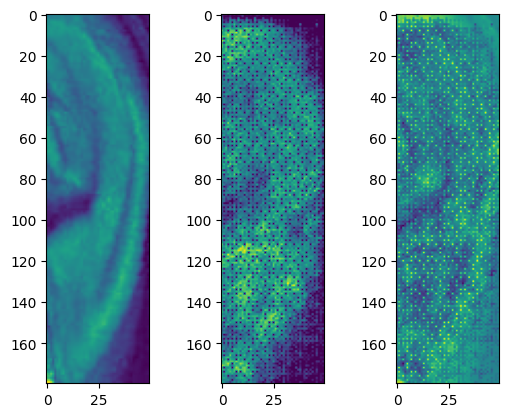

In [18]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(valid_input[0,:,:,:].permute(1,2,0).cpu().detach().numpy())
plt.subplot(1,3,2)
plt.imshow(decoded_input[0,:,:,:].permute(1,2,0).cpu().detach().numpy())
plt.subplot(1,3,3)
plt.imshow((valid_input-decoded_input)[0,:,:,:].permute(1,2,0).cpu().detach().numpy())